# RESTfulSwarm


In [54]:
# !pip install matplotlib
# !pip install seaborn pymongo numpy pandas

In [55]:
%matplotlib inline
import pymongo as mg
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


# return a mongodb client
def get_client(usr, pwd, address, port='27017'):
    url = 'mongodb://%s:%s@%s:%s/RESTfulSwarmDB' % (usr, pwd, address, port)
    return mg.MongoClient(url)


# return a database object
def get_db(client, db_name):
    return client[db_name]


# return a collection cursor object
def get_col(db, col_name):
    return db[col_name]


# query data in a job collection
def query_col(col):
    return list(col.find({}))[0]


# get a list of job collection name
def get_all_cols(db):
     return db.collection_names()

In [56]:
def get_time(data):
    result = {'waiting_time': 0, 'execution_time': 0, 'total_time': 0}
    if len(data) == 0:
        return None
    submit_time = data['submit_time']
    start_time = data['start_time']
    end_time = data['end_time']
    
    waiting_time = start_time - submit_time
    result['waiting_time'] = waiting_time
    
    execution_time = end_time - start_time
    result['execution_time'] = execution_time
    
    total_time = end_time - submit_time
    result['total_time'] = total_time
    return result


In [57]:
def plot_graph(db):
    cols = get_all_cols(db)
    data = {}
    waiting_time = []
    execution_time = []
    total_time = []
    jobs = []
    for col in cols:
        if 'job' not in col:
            continue
        col_obj = get_col(db, col)
        job_info = query_col(col_obj)
        session = job_info['job_name'].split('-')[1]
        result = get_time(job_info)
        if result['waiting_time'] <= 0 or result['execution_time'] <= 0 or result['total_time'] <= 0:
            continue
        if session not in data:
            data.update({session: {'waiting_time': [], 'execution_time': [], 'total_time': [], 'jobs': []}})
        data[session]['waiting_time'].append(result['waiting_time'])
        data[session]['execution_time'].append(result['execution_time'])
        data[session]['total_time'].append(result['total_time'])
        data[session]['jobs'].append(col)
    return data


In [58]:
client = get_client('admin', 'kzw', '129.59.234.223')
db = get_db(client, 'RESTfulSwarmDB')


In [59]:
def plot_waiting_time(waiting_time, jobs, session):
    wt = pd.Series(waiting_time, index=jobs)
    wt.plot.line(figsize=(10, 5))
    plt.xlabel('Job')
    plt.ylabel('Waiting Time(s)')
    plt.title('Job Waiting Time--%s' % session)

In [60]:
def plot_execution_time(execution_time, jobs, session):
    et = pd.Series(execution_time, index=jobs)
    et.plot.line(figsize=(10, 5))
    plt.xlabel('Job')
    plt.ylabel('Execution Time(s)')
    plt.title('Job Execution Time--%s' % session)


In [61]:
def plot_total_time(total_time, jobs, session):
    tt = pd.Series(total_time, index=jobs)
    tt.plot.line(figsize=(10, 5))
    plt.xlabel('Job')
    plt.ylabel('Total Time(s)')
    plt.title('Job Total Time--%s' % session)


In [62]:
def plot_resource_graph():
    workers_resource_col = get_col(db, 'WorkersResourceInfo')
    data = list(workers_resource_col.find({}))
    hostnames = [worker['hostname'] for worker in data]
    time_stamps = []
    for worker in data:
        for detail in worker['details']:
            time_stamps.append(detail[0])
    time_stamps = list(set(time_stamps))
    time_stamps.sort()
    utilization = np.zeros([len(hostnames), len(time_stamps)])
            
    def search_utilization(hostname, _time_stamp):
        for worker in data:
            if worker['hostname'] == hostname:
                for _detail in worker['details']:
                    if _detail[0] == _time_stamp:
                        return _detail[1]
        return 0
    
    for i, host in enumerate(hostnames[:]):
        for j, time_stamp in enumerate(time_stamps[:]):
            result = search_utilization(host, time_stamp)
            if result != -1:
                utilization[i, j] = result
            else:
                utilization[i, j] = utilization[i, j-1]
    
    df = pd.DataFrame(data=utilization, index=hostnames, columns=time_stamps)
    
    return sns.heatmap(data=df, vmin=0, vmax=1, center=0, cmap="Greens")

In [63]:
import numpy as np
import matplotlib.pyplot as plt


client = get_client('admin', 'root', '129.59.234.223')
db = get_db(client, 'RESTfulSwarmDB')

def graph_cdf(data, session):
    num_bins = 10
    counts, bin_edges = np.histogram (data, bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    print(bin_edges)
    print(counts)

    _label = '"Baseline Application Performance--%s' % session
    plt.plot (bin_edges[1:], cdf/cdf[-1], label=_label)
    plt.xlabel("Response Time in msec.")
    plt.ylabel("F(x)")
    plt.legend()


    for q in [50, 90, 95, 100]:
      print ("{}%% percentile: {}".format (q, np.percentile(data, q)))

In [64]:
graph_data = plot_graph(db)
sessions = list(graph_data.keys())
waiting_times = [d['waiting_time'] for d in list(graph_data.values())]
execution_times = [d['execution_time'] for d in list(graph_data.values())]
total_times = [d['total_time'] for d in list(graph_data.values())]
jobs = [d['jobs'] for d in list(graph_data.values())]

/home/zhuangwei/RESTfulSwarm/JupyterNoteBook/venv/lib/python2.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.


# Waiting Time

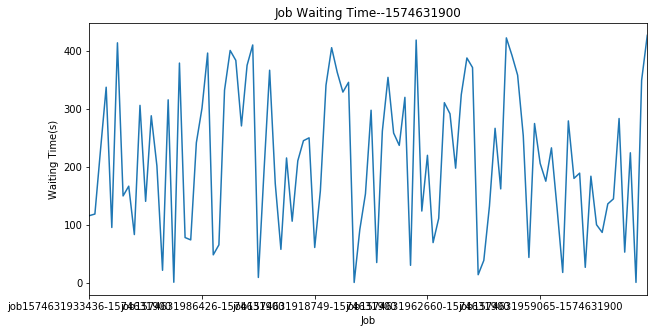

In [65]:
plot_waiting_time(waiting_times[0], jobs[0], sessions[0])

In [66]:
plot_waiting_time(waiting_times[1], jobs[1], sessions[1])

IndexError: list index out of range

In [ ]:
plot_waiting_time(waiting_times[2], jobs[2], sessions[2])

In [ ]:
plot_waiting_time(waiting_times[3], jobs[3], sessions[3])

# Execution Time

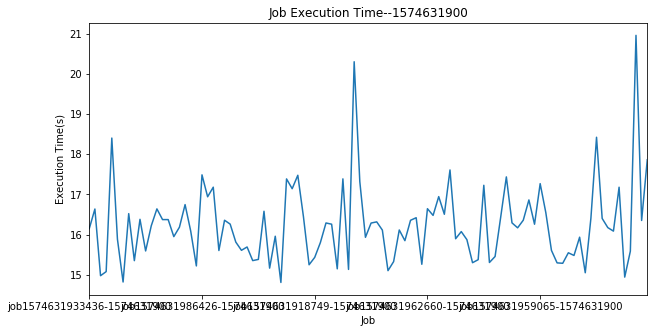

In [67]:
plot_execution_time(execution_times[0], jobs[0], sessions[0])

In [72]:
plot_execution_time(execution_times[1], jobs[1], sessions[1])

IndexError: list index out of range

In [ ]:
plot_execution_time(execution_times[2], jobs[2], sessions[2])

In [ ]:
plot_execution_time(execution_times[3], jobs[3], sessions[3])

# Total Time

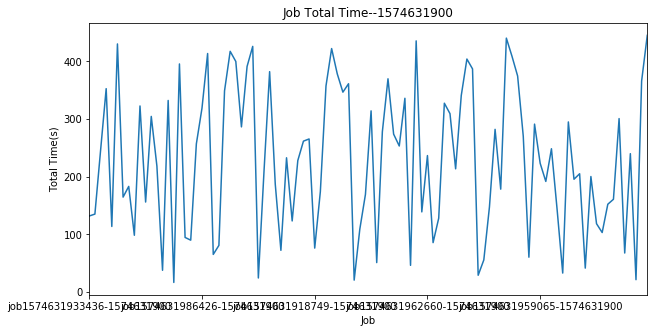

In [68]:
plot_total_time(total_times[0], jobs[0], sessions[0])

In [ ]:
plot_total_time(total_times[1], jobs[1], sessions[1])

In [ ]:
plot_total_time(total_times[2], jobs[2], sessions[2])

In [ ]:
plot_total_time(total_times[3], jobs[3], sessions[3])

# Resource Utilization

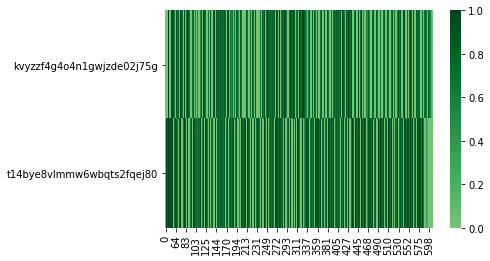

In [70]:
for session in graph_data:
    plot_resource_graph()

# Waiting Time CDF

[  0.50743222  43.1951545   85.88287678 128.57059906 171.25832133
 213.94604361 256.63376589 299.32148817 342.00921044 384.69693272
 427.384655  ]
[0.00257685 0.00234259 0.00234259 0.00234259 0.00210833 0.00234259
 0.00234259 0.00234259 0.00234259 0.00234259]
50%% percentile: 213.146627069
90%% percentile: 384.56678257
95%% percentile: 406.320414448
100%% percentile: 427.384654999


/home/zhuangwei/RESTfulSwarm/JupyterNoteBook/venv/lib/python2.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


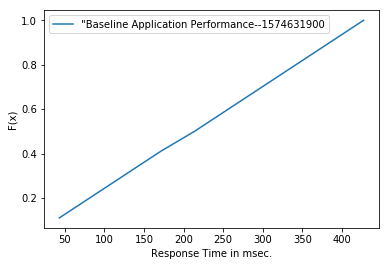

In [69]:
for session in graph_data:
    waiting_time = graph_data[session]['waiting_time']
    graph_cdf(waiting_time, session)

# Execution Time CDF

[14.80516219 15.42112176 16.03708134 16.65304091 17.26900048 17.88496006
 18.50091963 19.1168792  19.73283877 20.34879835 20.96475792]
[0.3571663  0.32469663 0.60068877 0.14611349 0.12987865 0.03246966
 0.         0.         0.01623483 0.01623483]
50%% percentile: 16.1775199175
90%% percentile: 17.3860276461
95%% percentile: 17.6219900846
100%% percentile: 20.9647579193


/home/zhuangwei/RESTfulSwarm/JupyterNoteBook/venv/lib/python2.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


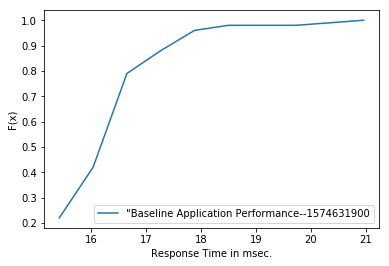

In [71]:
for session in graph_data:
    execution_time = graph_data[session]['execution_time']
    graph_cdf(execution_time, session)

# Total Time CDF

[ 16.79147363  59.6370831  102.48269258 145.32830205 188.17391152
 231.019521   273.86513047 316.71073995 359.55634942 402.40195889
 445.24756837]
[0.00256736 0.00233396 0.00233396 0.00233396 0.00210057 0.00233396
 0.00233396 0.00233396 0.00233396 0.00233396]
50%% percentile: 230.578009605
90%% percentile: 400.383666348
95%% percentile: 422.532284176
100%% percentile: 445.247568369


/home/zhuangwei/RESTfulSwarm/JupyterNoteBook/venv/lib/python2.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


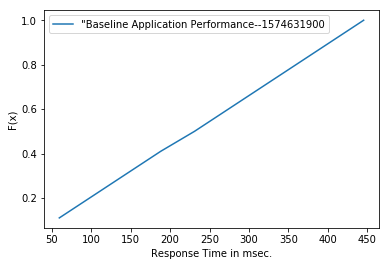

In [73]:
for session in graph_data:
    total_time = graph_data[session]['total_time']
    graph_cdf(total_time, session)